# ECMM416DA (Learning From Data) - Coursework

In [3641]:
!pip list

11917.78s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Package           Version
----------------- -----------
appnope           0.1.4
asttokens         2.4.1
comm              0.2.2
contourpy         1.2.1
cycler            0.12.1
debugpy           1.8.2
decorator         5.1.1
executing         2.0.1
fonttools         4.53.1
imbalanced-learn  0.12.3
ipykernel         6.29.5
ipython           8.26.0
jedi              0.19.1
joblib            1.4.2
jupyter_client    8.6.2
jupyter_core      5.7.2
kiwisolver        1.4.5
matplotlib        3.9.1
matplotlib-inline 0.1.7
nest-asyncio      1.6.0
numpy             2.0.1
packaging         24.1
pandas            2.2.2
parso             0.8.4
pexpect           4.9.0
pillow            10.4.0
pip               24.1.2
platformdirs      4.2.2
prompt_toolkit    3.0.47
psutil            6.0.0
ptyprocess        0.7.0
pure_eval         0.2.3
Pygments          2.18.0
pyparsing         3.1.2
python-dateutil   2.9.0.post0
pytz              2024.1
pyzmq             26.0.3
scikit-learn      1.5.1
scipy          

In [3642]:
# All packages used
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
from sklearn.metrics import confusion_matrix

For this assignment, the Online Shoppers Purchasing Intention Dataset is investigated.  It is provided as a csv file which is loaded below.

There will be overlap between this notebook and the written report as I believe that it is important to tell a story through the processing in the notebook.

Research question: Can the purchase intention be predicted using logistic regression or decision tree models?

Models: Logistic regression, decision tree

In [3643]:
data = pd.read_csv('online_shoppers_intention.csv')
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


## Data Exploration

In this section I evaluate each column in the data and decide if it should move on to be processed in the feature engineering section.

The data set contains 18 columns related to various aspects of the shoppers behavior:
* Administrative
* Administrative_Duration
* Informational
* Informational_Duration
* ProductRelated
* ProductRelated_Duration
* BounceRates
* ExitRates
* PageValues
* SpecialDay
* Month
* OperatingSystems
* Browser
* Region
* TrafficType
* VisitorType
* Weekend
* Revenue

Each of the 12,330 rows represents a single shopping session in which a user has visited the website.

### Output Classification

The column that indicates if there was a purchase in the session is called 'Revenue'.

In [3644]:
def plot_bar(data, column, title):
    total = len(data)

    fig, ax = plt.subplots()

    sns.countplot(x=column, data=data, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    plt.title(title)

    # add annotations
    for c in ax.containers:
        labels = [f'{h/data[column].count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='edge')

    plt.show()

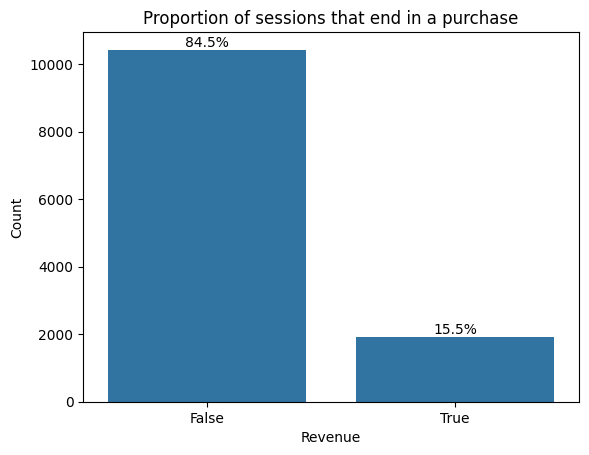

In [3645]:
plot_bar(data, 'Revenue', 'Proportion of sessions that end in a purchase')

As you would expect, the majority of sessions do not have a purchase.  To ensure that any models are trained well, the dataset should be leveled through a process such as over/undersampling.

### Pages Visited

There are 6 columns related to the type of page visited on the website.  Administrative, Informational and ProductRelated are counts for the type of page. Administrative_Duration, Informational_Duration and ProductRelated_Duration are the time spent on each type of page.

The column pairs such as Administrative and Administrative_Duration are quite similar conceptually, so it is worth checking if there is a correlation between them.

In [3646]:
def print_column_correlation(column_1, column_2):
    correlation = data[column_1].corr(data[column_2])
    print(f"{column_1}, {column_2} correlation: " + str(correlation))

In [3647]:
# Print correlations
print_column_correlation('Administrative', 'Administrative_Duration')
print_column_correlation('Informational', 'Informational_Duration')
print_column_correlation('ProductRelated', 'ProductRelated_Duration')

Administrative, Administrative_Duration correlation: 0.6015833421250232
Informational, Informational_Duration correlation: 0.618954861781457
ProductRelated, ProductRelated_Duration correlation: 0.8609268361763696


In [3648]:
def plot_scatter(data: pd.DataFrame, x_name: str, x_units: str, y_name:str, y_units:str, mean=False):
    x_data = data[x_name]
    y_data = data[y_name]

    fig = plt.figure()
    ax1 = fig.add_subplot()  
    ax1.scatter(x_data, y_data, label='Data Points')
    if mean:
        mean_points = data.groupby(x_name)[y_name].transform('mean')
        ax1.scatter(x_data, mean_points, label='Mean')
        plt.legend()
    ax1.set_xlabel(x_name + ' ' + x_units)
    ax1.set_ylabel(y_name + ' ' + y_units)
    plt.title(x_name + ' vs ' + y_name)
    plt.show()

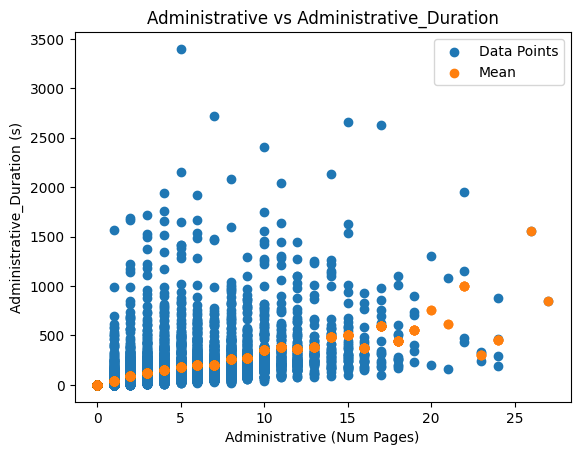

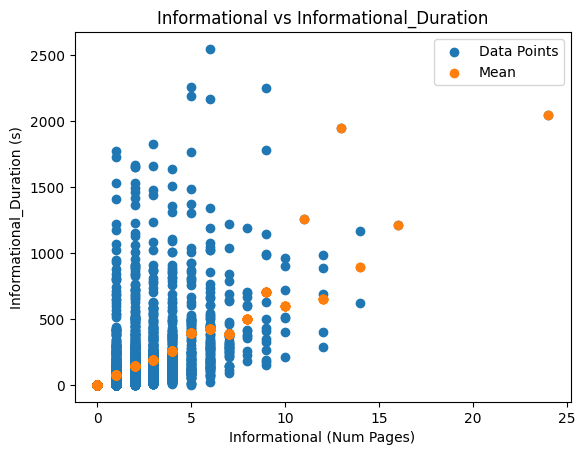

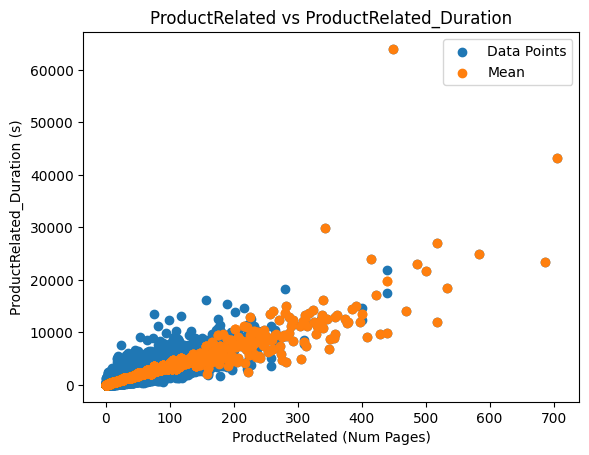

In [3649]:
# Data scatter plots with the mean for each x value
plot_scatter(data, 'Administrative', '(Num Pages)', 'Administrative_Duration', '(s)',True)
plot_scatter(data, 'Informational', '(Num Pages)', 'Informational_Duration', '(s)',True)
plot_scatter(data, 'ProductRelated', '(Num Pages)', 'ProductRelated_Duration', '(s)',True)

As you would expect from simple intuition there is some correlation between each pair where as the number of pages visited increases, the time spent also increases.  However, the correlation is not strong enough to exclude any columns (would want a value of at least 0.9).

Next, the distribution of each column is plotted.

In [3650]:
def plot_2_hist(data: pd.DataFrame, column_1: str, column_2: str, bins: int):
    fig, (ax0, ax1) = plt.subplots(figsize=(12, 6), nrows=1, ncols=2)

    ax0.hist(data[column_1], bins)
    ax1.hist(data[column_2], bins)
    ax0.set_xlabel(column_1)
    ax0.set_ylabel('Count')
    ax1.set_xlabel(column_2)
    ax1.set_ylabel('Count')

    fig.tight_layout()
    plt.show()
    print(f'{column_1} skew: ' + str(data[column_1].skew()))
    print(f'{column_2} skew: ' + str(data[column_2].skew()))

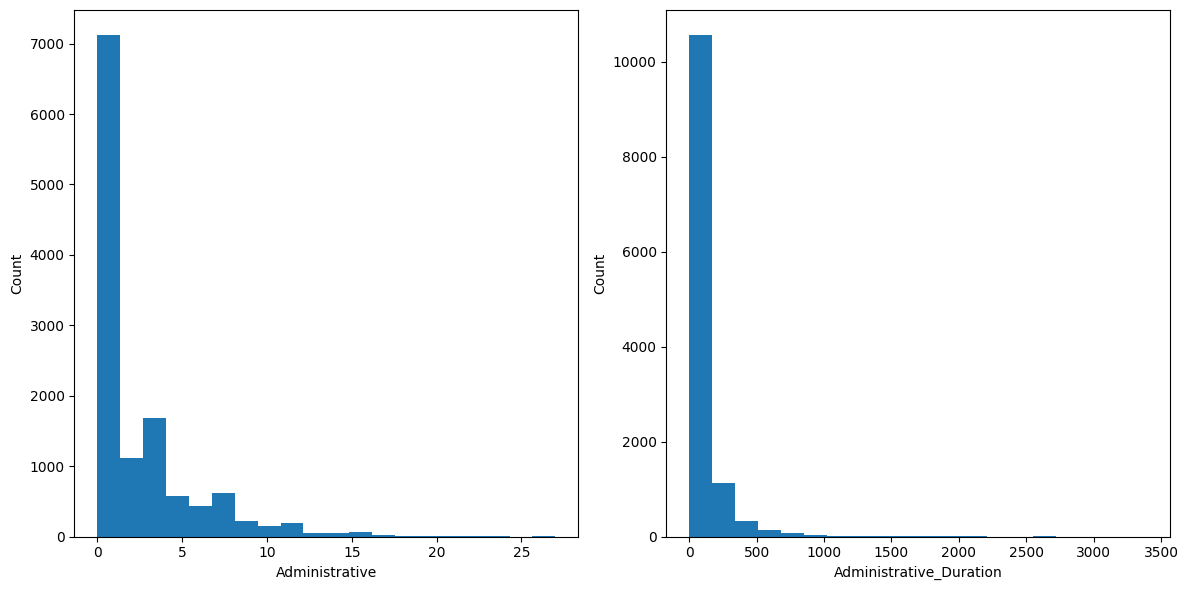

Administrative skew: 1.9603572090790138
Administrative_Duration skew: 5.61571901877419


In [3651]:
plot_2_hist(data, 'Administrative', 'Administrative_Duration', 20)

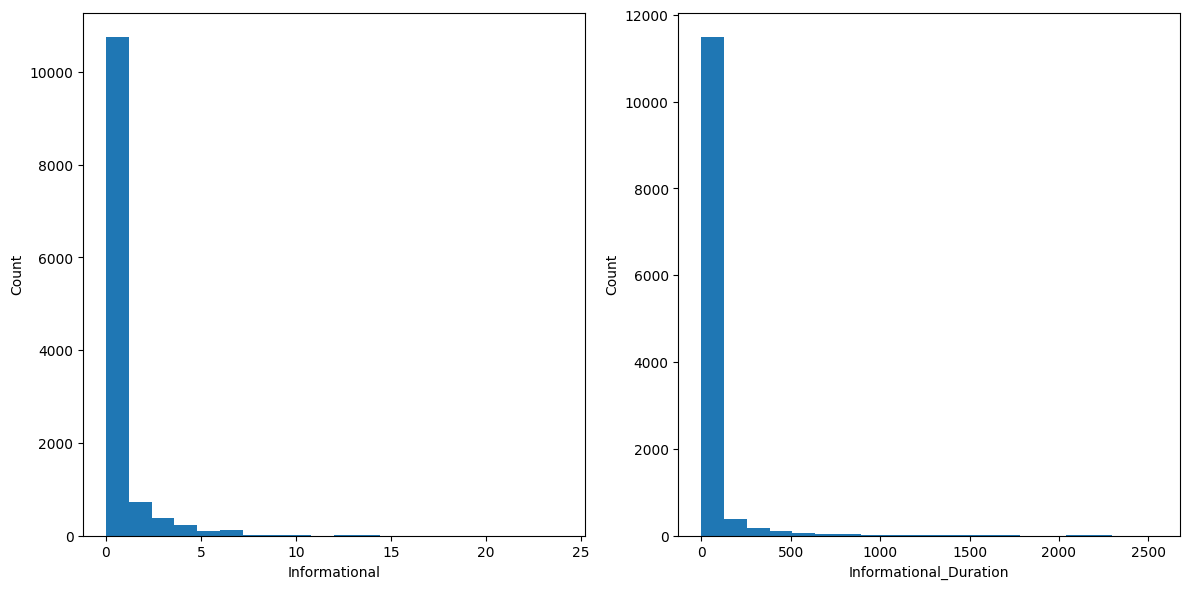

Informational skew: 4.036463759943139
Informational_Duration skew: 7.579184715734214


In [3652]:
plot_2_hist(data, 'Informational', 'Informational_Duration', 20)

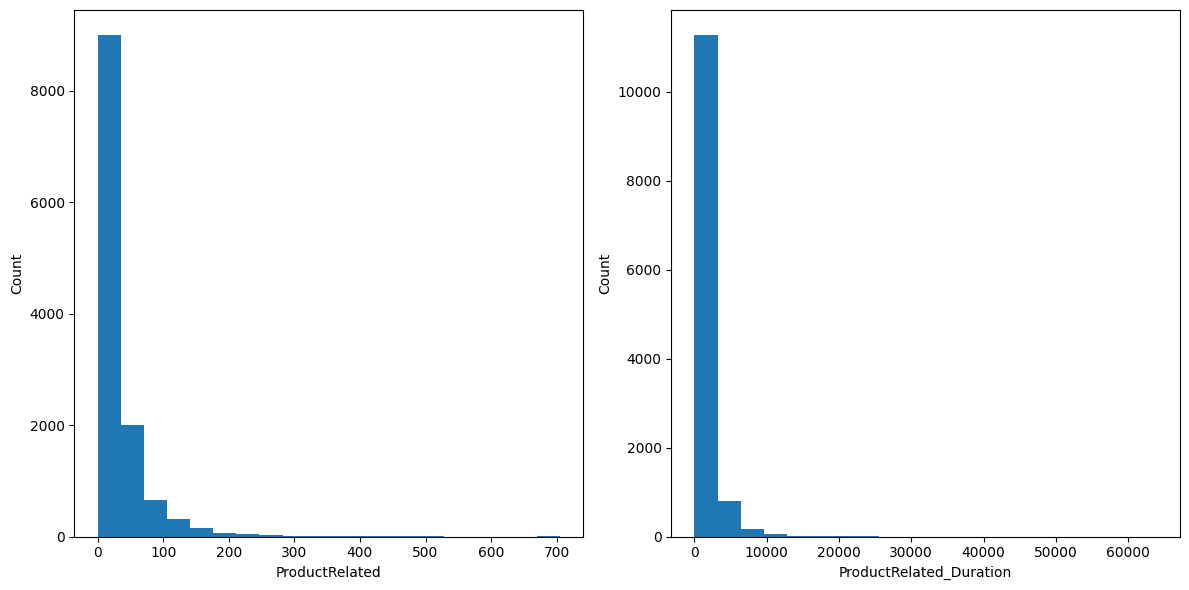

ProductRelated skew: 4.341516415550065
ProductRelated_Duration skew: 7.263227682561318


In [3653]:
plot_2_hist(data, 'ProductRelated', 'ProductRelated_Duration', 20)

It can be seen that all of the columns have a heavy positive skew due to the large number of 0s in each column.

Because a large proportion of these columns are 0, logistic regression would likely be a poor method of modelling.  Some transformations could be used to adjust the data to be more Gaussian, but there is not really anything that can be done for the high proportion of 0s.

One thing that I could try is splitting the columns into multiple features.  So there would be an is_zero column which is either a True or False.  The other column is the values if the column is not zero, otherwise it would be null.  The nulls are then filled in with some standard method for dealing with nulls when modelling such as filling them with the mean. 

### Page Behavior

There are 3 columns related to page behavior: BounceRates, ExitRates, PageValues.

BounceRates = "the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session."

ExitRates = "feature for a specific web page is calculated as for all pageviews to the page, the percentage that were the last in the session."

PageValues = "the average value for a web page that a user visited before completing an e-commerce transaction."

In [3654]:
def plot_hist(data: pd.DataFrame, column: str, bins: int):
    data[column].hist(bins=bins)
    print(f"{column} skew: " + str(data[column].skew()))

BounceRates skew: 2.947855266695535


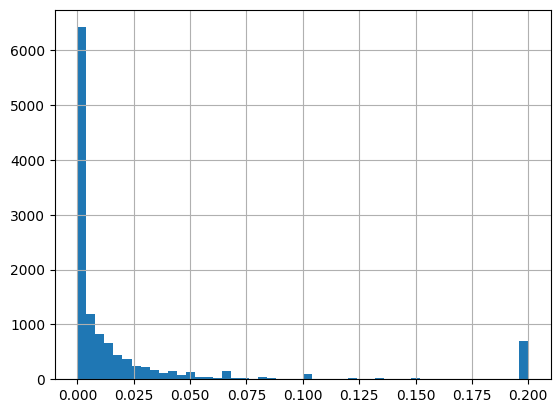

In [3655]:
# plot distribution for Bounce rate
plot_hist(data, 'BounceRates', 50)

ExitRates skew: 2.1487889999009804


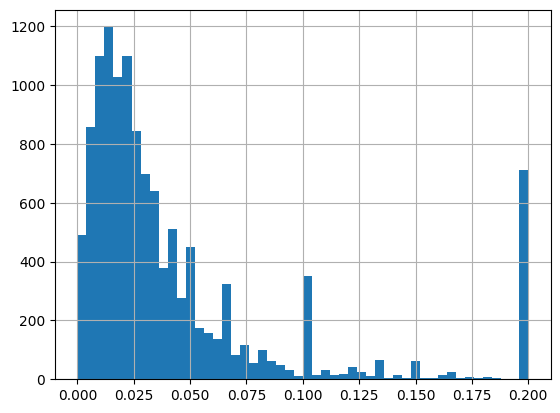

In [3656]:
# plot distribution for Exit rate
plot_hist(data, 'ExitRates', 50)


In [3657]:
print_column_correlation('BounceRates', 'ExitRates')

BounceRates, ExitRates correlation: 0.9130043961815202


Bounce rate and exit rate are highly correlated (>0.9) therefore only one of the columns will be used.  Exit rate has a better distribution, therefore it will be used and bounce rate will be dropped.

It is not exactly clear what Page value measures, but if it measures the pages visited until a purchase hase been made, there should only be values for users who have purchased something in the session or who are returning users who have already purchased something.

In [3658]:
page_values = data.loc[data['PageValues'] != 0]
new_user_test = page_values.loc[(page_values['VisitorType'] == 'New_Visitor') & (page_values['Revenue'] is False)]
new_user_test

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue


The test has returned 0 rows, therefore it is safe to assume that this is the meaning of the column.
This column is not useful for the question being answered, but can be used to create a new column which indicates whether a user has bought something before.

### Date

There are 3 columns related to dates: SpecialDay, Month and Weekend.

SpecialDay = "indicates the closeness of the site visiting time to a specific special day (e.g. Mother’s Day, Valentine's Day) in which the sessions are more likely to be finalized with transaction."

Month = the month in which the session took place

Weekend = boolean which indicates if a session occurred on the weekend

SpecialDay can be the discrete values: 0, 0.2, 0.4, 0.6, 0.8, 1 depending on how close a session is to a holiday.  1 is close to a holiday and 0 is not.

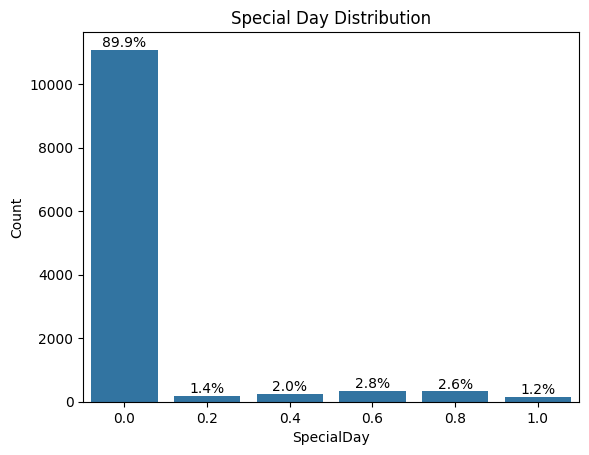

In [3659]:
# plot distribution for special day
plot_bar(data, 'SpecialDay', 'Special Day Distribution')

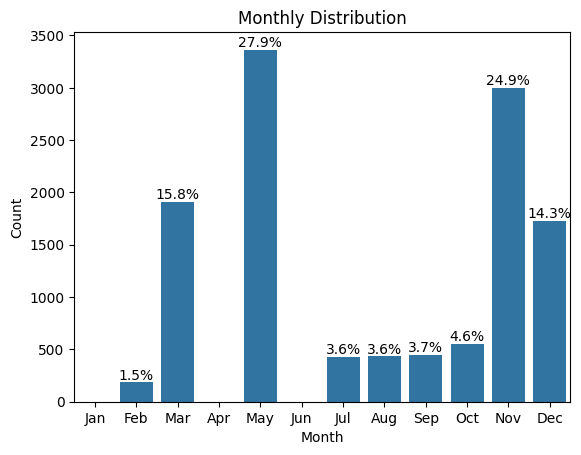

In [3660]:
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
          "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
# making a copy and changing it to be ordered by month
data_month = data.copy()
data_month['Month'] = pd.Categorical(data_month['Month'], categories=months, ordered=True)
data_month = data_month.sort_values(by='Month')
# plot distribution for month
plot_bar(data_month, 'Month', 'Monthly Distribution')

There is not a uniform distribution of sessions across the year and January, April, June have no data.  To prevent any model from making poor inferences from this data. it is worth dropping.

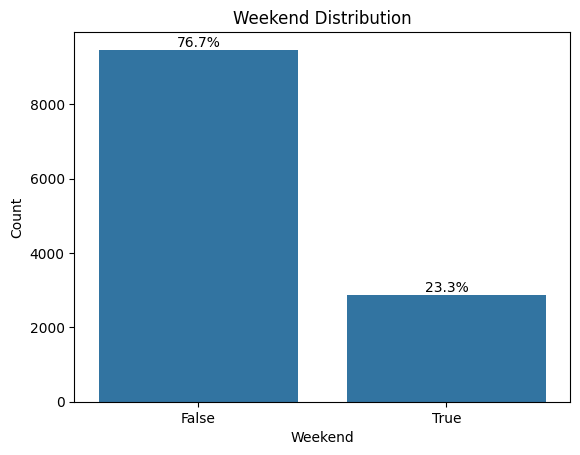

In [3661]:
# plot distribution for weekend
plot_bar(data, 'Weekend', 'Weekend Distribution')

There are less sessions on the weekend in the dataset.  This suggests that the number of sessions on week days and weekends are relatively similar as 5/7 = 71%.

### Visitor Characteristics

There are 5 columns related to visitor characteristics: OperatingSystems, Browser, Region, TrafficType, VisitorType.

The first 4 of these are unlikely to have an effect on the purchase prediction and can be excluded.  They are also already numerically encoded with no mapping available, making the information difficult to interpret.

VisitorType is useful and contains 'Returning_Visitor' or 'New_Visitor'.

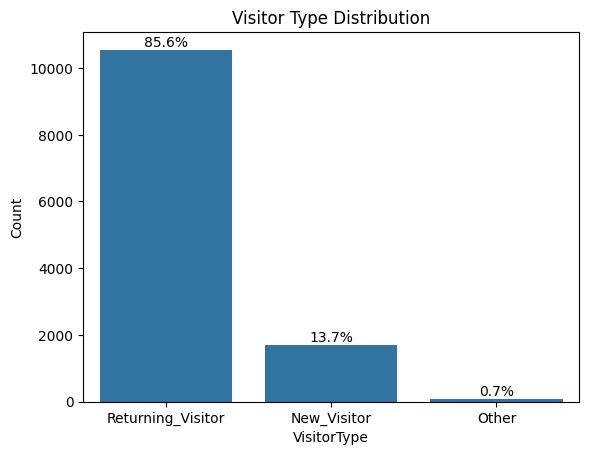

In [3662]:
# plot distribution for visitor type
plot_bar(data, 'VisitorType', 'Visitor Type Distribution')

Looking at the distribution, there is a third category called 'Other'.  It is not clear what this refers to, but it is only a small proportion of the data.

### Missing Data Check

Checking the data to see if there are any missing values.

In [3663]:
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

The data does not appear to be missing anything.

## Feature Engineering

Order of changes made:
1. Drop unwanted columns
2. Generate new columns
3. Train, test split
4. Fill in nulls
5. Transformations
6. Category encoding
7. Scaling
8. Oversampling

Ordered in such a way to keep any models completely unaware of the test set.

### Drop Columns

Removing columns that I have no interest in (as defined in the initial investigation).

In [3664]:
columns_to_drop = ['BounceRates', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month']
data = data.drop(columns_to_drop, axis=1)

### Split Columns

As mentioned before, I'm splitting the heavily skewed columns into multiple columns where one is flags if the value is 0 or not and the other contains not 0 values.

In [3665]:
# Columns to split
skewed_columns = ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration',
                        'ProductRelated', 'ProductRelated_Duration']
zero_columns = []
null_columns = []
for column in skewed_columns:
    # 0 flag columns
    zero_column_name = column + '_is_zero'
    data[zero_column_name] = np.where(data[column] == 0, 1, 0)
    zero_columns.append(zero_column_name)
    
    # Not 0 columns
    null_column_name = column + '_null'
    data[null_column_name] = np.where(data[column] == 0, None, data[column])
    null_columns.append(null_column_name)

print(zero_columns)
print(null_columns)

['Administrative_is_zero', 'Administrative_Duration_is_zero', 'Informational_is_zero', 'Informational_Duration_is_zero', 'ProductRelated_is_zero', 'ProductRelated_Duration_is_zero']
['Administrative_null', 'Administrative_Duration_null', 'Informational_null', 'Informational_Duration_null', 'ProductRelated_null', 'ProductRelated_Duration_null']


### Change Page Values Column

As mentioned in the data exploration section, page value refers to the time taken until a purchase has been made.  This is converted into 'PurchaseBefore' which is 1 when a returning user has bought something on a previous visit.  Otherwise, it will be 0 (always 0 for new visitors).

In [3666]:
# Create and fill new column
data['PurchaseBefore'] = 0
data.loc[(data['PageValues'] != 0) & (data['VisitorType'] == 'Returning_Visitor'), 'PurchaseBefore'] = 1
print(data[['PageValues', 'VisitorType', 'PurchaseBefore']])
# Removing PageValues from the data as it is no longer needed
data = data.drop(['PageValues'], axis=1)

       PageValues        VisitorType  PurchaseBefore
0        0.000000  Returning_Visitor               0
1        0.000000  Returning_Visitor               0
2        0.000000  Returning_Visitor               0
3        0.000000  Returning_Visitor               0
4        0.000000  Returning_Visitor               0
...           ...                ...             ...
12325   12.241717  Returning_Visitor               1
12326    0.000000  Returning_Visitor               0
12327    0.000000  Returning_Visitor               0
12328    0.000000  Returning_Visitor               0
12329    0.000000        New_Visitor               0

[12330 rows x 3 columns]


### Train, Test Split

Splitting the data into a training and test set (30% of the data for testing).

In [3667]:
y_name = 'Revenue'
X = data.loc[:, data.columns != y_name]
y = data[y_name]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)  

Checking that the split between each binary category is reasonable for the train and test sets.

In [3668]:
y_train.value_counts()

Revenue
False    7298
True     1333
Name: count, dtype: int64

In [3669]:
y_test.value_counts()

Revenue
False    3124
True      575
Name: count, dtype: int64

The splits are fine.  18% of the samples in train are purchase sessions and 18% in test.

### Column Transformations

In [3670]:
set_config(transform_output="pandas")

In [3671]:
standard_columns = X_train.columns[~X_train.columns.isin(zero_columns + null_columns)]

In [3672]:
set_1_columns = standard_columns
set_1_categorical_columns = ['VisitorType']
set_1_not_categorical_columns = [x for x in set_1_columns if x not in set_1_categorical_columns]

In [3673]:
set_1_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(sparse_output=False), categoricals),
    ('scaler', MinMaxScaler(), not_categorical_columns),
    
])

In [3674]:
set_2 = ColumnTransformer(transformers=[
])

In [3675]:
set_3 = ColumnTransformer(transformers=[
])

In [3676]:
set_1 = X_train[standard_columns]
set_1 = set_1_transformer.fit_transform(set_1)

## Evaluation Metrics

In [3677]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['No Purchase', 'Purchase']

## Modelling

In [3678]:
def create_run_pipeline(grid, steps):
    pipeline = Pipeline(steps=steps)
    model = GridSearchCV(estimator=pipeline, param_grid=grid, cv=5)
    model.fit(X_train, y_train)
    return model

In [3679]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    hyperparamters = model_set_1.best_params_
    return cnf_matrix, hyperparamters

### Model 1 - Logistic Regression

In [3680]:
log_grid = {
    'model__C': [100, 10, 1, 0.1, 0.01],
    'model__solver' : ['newton-cg', 'lbfgs', 'liblinear']
}

In [3681]:
set_1_steps = [
    ('col_transformer', set_1_transformer),
    ('model', LogisticRegression())
]

set_1_steps_over = [
    ('col_transformer', set_1_transformer),
    ('over_sample', RandomOverSampler(sampling_strategy='minority', random_state=42)),
    ('model', LogisticRegression())
]

In [3682]:
model_set_1 = create_run_pipeline(log_grid, set_1_steps)
set_1_matrix, set_1_hyper = evaluate_model(model_set_1, X_test, y_test)
set_1_hyper

{'model__C': 1, 'model__solver': 'lbfgs'}

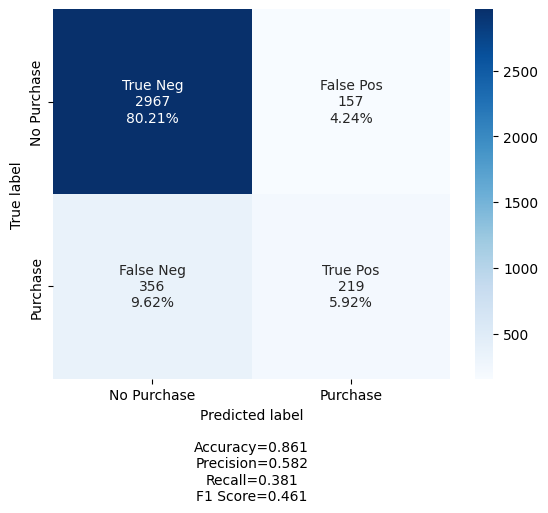

In [3683]:
make_confusion_matrix(set_1_matrix,
                    group_names=labels,
                    categories=categories)

In [3684]:
model_set_1_over = create_run_pipeline(log_grid, set_1_steps_over)
set_1_over_matrix, set_1_over_hyper = evaluate_model(model_set_1_over, X_test, y_test)
set_1_over_hyper

{'model__C': 1, 'model__solver': 'lbfgs'}

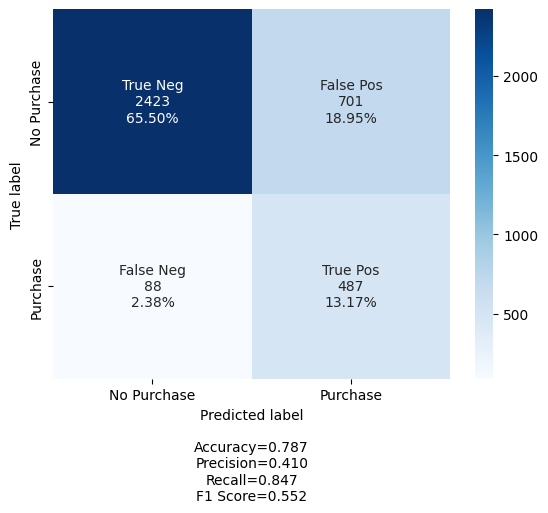

In [3685]:
make_confusion_matrix(set_1_over_matrix,
                    group_names=labels,
                    categories=categories)